# Confusion Matrix by 이승훈

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
print("sklearn version: ", sklearn.__version__)
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
print("TF version: ", tf.__version__)
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=4)
mpl.rc('xtick', labelsize=4)
mpl.rc('ytick', labelsize=4)
mpl.rc('font',size=2)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")    

from tensorflow.python.keras.utils.data_utils import Sequence

sklearn version:  0.24.2
TF version:  2.8.0
GPU installed:  True
1 Physical GPUs, 1 Logical GPUs


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from __future__ import print_function
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
import random




class Inveted_Residual_Block(keras.layers.Layer):
    def __init__(self,c,s=1,t=1,n=1,**kwargs):
        super().__init__(**kwargs)
        self.activation = keras.layers.ReLU(max_value=6)
        self.main_layers = [
            
            ]
        self.strides_layers=[
           ]
        self.s=s
        self.t=t
        self.c=c
        self.n=n
        
    def build(self,batch_input_shape):
        print(self.name,": batch_input_shape =",batch_input_shape)
        
        self.main_layers = [
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=batch_input_shape[-1]*self.t, kernel_size=1,strides=1, 
                                padding="SAME", activation=self.activation),
            keras.layers.BatchNormalization(),
            keras.layers.DepthwiseConv2D(kernel_size=3, strides=1,padding="SAME", activation=self.activation),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=self.c,kernel_size=1, strides=1,padding="SAME", activation=self.activation),
            ]
        self.strides_layers=[
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=batch_input_shape[-1]*self.t, kernel_size=1,strides=1,
                                padding="SAME", activation=self.activation),
            keras.layers.BatchNormalization(),
            keras.layers.DepthwiseConv2D(kernel_size=3, strides=self.s,padding="SAME",activation=self.activation),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=self.c, kernel_size=1,strides=1,padding="SAME",activation=self.activation),
        ]

    def call(self, inputs):
        Z = inputs
        
        for n in range(0,self.n):
            if n == 0:
                for layer in self.strides_layers:
                    Z = layer(Z)
            else:
                skip_Z = Z
                for layer in self.main_layers:
                    Z = layer(Z)
                
                Z += skip_Z
    
        return Z
    
    def get_config(self):
        base=super().get_config()
        return{**base,"s":self.s,"t":self.t,"c":self.c,"n":self.n}

In [4]:
@tf.function
def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[1:])
    x=tf.reshape(x,[28,28,1])
    y = tf.stack(fields[:1])
    augment_image = x
    if y > 10:
        augment_image = dataaugmentation(x)
        
        
    resized_image = tf.image.resize(augment_image, [224, 224])
    if resized_image.shape[2] == 1:
        temp=tf.concat([resized_image,resized_image],2)
        resized_image=tf.concat([temp,resized_image],2)
    final_image = keras.applications.mobilenet.preprocess_input(resized_image)
    
    return final_image, y

def dataaugmentation(X):
    datagen=ImageDataGenerator(rotation_range=40,width_shift_range = 0.2, 
        height_shift_range = 0.2)
    #영어 부분 2배 생성
    #차원변환 
    X=tf.reshape(X,[28,28,1])

    #새로운 데이터 생성
    angle=(random.random()%1)*1.4-0.7
    image_result =tfa.image.rotate(X, tf.constant(angle))#rotate -pi/4 ~ pi/4
    shift=(random.random()%1)*8-4
    image_result=tfa.image.translate(image_result,[tf.constant(shift),tf.constant(shift)])
    
    return image_result

In [5]:
#황성현
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    
    Emnist_dir = os.path.join("./common_file", "Emnist")
    os.makedirs(Emnist_dir, exist_ok=True)
    path_format = os.path.join(Emnist_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        try:
            with open(part_csv, "xt", encoding="utf-8") as f:
                if header is not None:
                    f.write(header)
                    f.write("\n")
                for row_idx in row_indices:
                    f.write(",".join([repr(col) for col in data[row_idx]]))
                    f.write("\n")
        except:
            continue
    return filepaths

In [6]:
#csv_reader_dataset에서 shuffle을 없앤것
def csv_reader_conf_dataset(filepaths, repeat=1, n_readers=1,
                       n_read_threads=None, shuffle_buffer_size=0,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths,shuffle=False).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [18]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def data_to_confusion(model,dataset,batch_size,steps):
    y_pred=model.predict(dataset,batch_size=batch_size, steps=steps)
    y_pred_classes=np.argmax(y_pred,axis=1)
    y_true=[]
    y_true=np.resize(y_true,[0,1])
    i=0
    for x,y in dataset:
        y_true=tf.concat([y_true,y],0)
        i+=1
        if i==steps:
            break
    cf=confusion_matrix(y_true,y_pred_classes)
    return cf

In [23]:
def save_confusion_matrix(confusion_matrix, label, filename="confusion_matrix.png"):
    cm=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,display_labels=label)
    plt.figure(dpi=300)
    cm.plot()
    plt.savefig(filename,dpi=300)
    

In [9]:
y_valid=np.loadtxt('./common_file/valid_label.csv', delimiter=",",dtype='uint8')
X_valid=np.loadtxt('./common_file/valid_data.csv', delimiter=",",dtype='uint8')

In [10]:
X_valid=np.reshape(X_valid,[-1,784])
y_valid=np.reshape(y_valid,[-1,1])

y_valid.shape,X_valid.shape

((164015, 1), (164015, 784))

In [11]:
valid_full=np.append(y_valid, X_valid, axis=1)
valid_full.shape

(164015, 785)

In [14]:
#batch_size * steps=len(data)
batch_size=5
steps=32803
n_inputs = X_valid.shape[-1]

In [15]:
valid_filepaths=save_to_multiple_csv_files(valid_full,"valid",n_parts=20)

valid_set=csv_reader_conf_dataset(valid_filepaths,batch_size=batch_size, repeat=None)

In [16]:
model1=keras.models.load_model('./smv2p_nadam_best.h5',custom_objects={'Inveted_Residual_Block':Inveted_Residual_Block})

IRB1 : batch_input_shape = (None, 112, 112, 32)
IRB2 : batch_input_shape = (None, 112, 112, 16)
IRB3 : batch_input_shape = (None, 56, 56, 32)
IRB4 : batch_input_shape = (None, 28, 28, 64)
IRB5 : batch_input_shape = (None, 14, 14, 64)
IRB6 : batch_input_shape = (None, 7, 7, 128)


In [19]:
smv2p_confusion_matrix=data_to_confusion(model1, valid_set, batch_size=batch_size, steps=steps)

In [20]:
byclass_labels=['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

<Figure size 1800x1200 with 0 Axes>

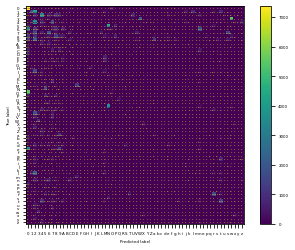

In [24]:
save_confusion_matrix(smv2p_confusion_matrix,label=byclass_labels,filename="SMV2_confusion_matrix.png")